In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

### Defining Transforms

In [2]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [3]:
from torch.utils.data import Dataset
from PIL import Image
from torch.utils.data.sampler import SubsetRandomSampler

class MyDataset(Dataset):
    def __init__(self, root_dir, label_file, class_names, class_to_idx, transform=None):
        self.root_dir = root_dir
        self.label_file = label_file
        self.class_names = class_names
        self.class_to_idx = class_to_idx
        self.transform = transform

        # Read the labels from the Excel file
        self.labels = pd.read_excel(label_file, usecols=[3], names=['smiling'])['smiling'].tolist()

        # Get the list of image files (without the lambda it was not in order)
        self.image_files = []
        for root, dirs, files in os.walk(root_dir): 
            self.image_files.extend([os.path.join(root, file) for file in sorted(files, key=lambda x: int(''.join(filter(str.isdigit, x))))])

        
        # print(self.labels)
        # print(self.image_files)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load the image and apply the transformation
        image = Image.open(self.image_files[idx])
        if self.transform:
            image = self.transform(image)

        # Convert the label to a tensor
        label = torch.tensor(self.labels[idx])
        
        return image, label

# Define the root directory of the dataset and the label file
root_dir = r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0134_AMLS1\dataset_AMLS_22-23\celeba\img'
label_file = r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0134_AMLS1\dataset_AMLS_22-23\celeba\labels.xlsx'
root_dir_test = r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0134_AMLS1\dataset_AMLS_22-23_test\celeba_test\img'
label_file_test = r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0134_AMLS1\dataset_AMLS_22-23_test\celeba_test\labels.xlsx'

# Define the class names and their corresponding indexes
class_names = ['Smiling', 'NotSmiling']
class_to_idx = {'Smiling': 1, 'NotSmilin': -1}

train_data = MyDataset(root_dir, label_file, class_names, class_to_idx, transform=train_transform)
test_data = MyDataset(root_dir_test, label_file_test, class_names, class_to_idx, transform=test_transform)

torch.manual_seed(42)
val_ratio = 0.2 # ratio of the validation set (e.g., 0.2 for 20% of the data)
indices = torch.randperm(len(train_data)).tolist() # Get the indices of the data points in the training set
val_size = int(val_ratio * len(train_data)) # number of data points in the validation set

# Split the indices into training and validation sets
val_indices = indices[:val_size]
train_indices = indices[val_size:]

# Create the samplers for the training and validation sets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Create the DataLoader objects for the training and validation sets
train_loader = DataLoader(train_data, batch_size=125, sampler=train_sampler)
val_loader = DataLoader(train_data, batch_size=125, sampler=val_sampler)
test_loader = DataLoader(test_data, batch_size=125, shuffle=True)

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')



['Smiling', 'NotSmiling']
Training images available: 5000
Testing images available:  1000


Displaying a batch of images

Label: [ 1  1 -1  1  1 -1 -1 -1 -1 -1]
Class: Smiling Smiling NotSmiling Smiling Smiling NotSmiling NotSmiling NotSmiling NotSmiling NotSmiling


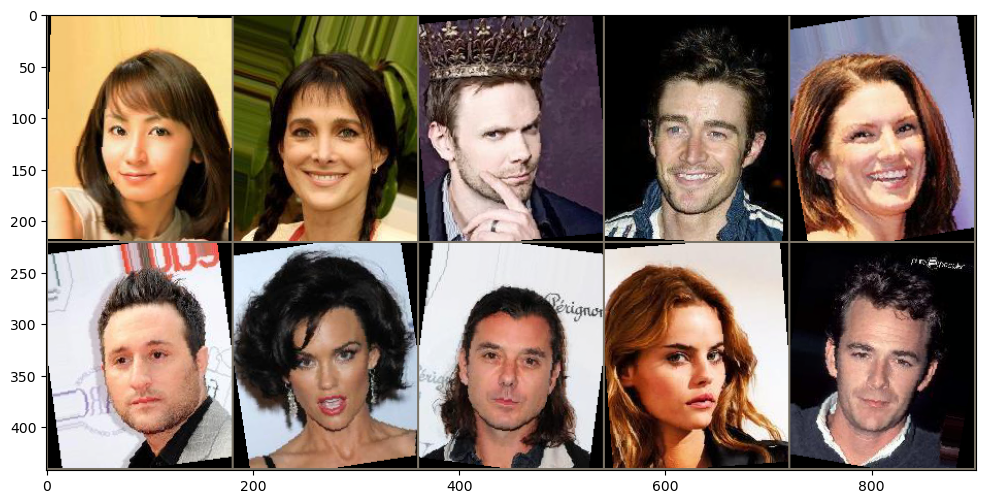

In [4]:
# Grab the first batch of images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels[:10].numpy())
print('Class:', *np.array(['NotSmiling' if x == -1 else 'Smiling' for x in labels[:10].numpy()]))

im = make_grid(images[:10], nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,16))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));


# Defining the model

In [5]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        # (((178−2)/2)−2)/2=43
        # (((218−2)/2)−2)/2=53
        self.fc1 = nn.Linear(43*53*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 43*53*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [6]:
torch.manual_seed(42)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=36464, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [7]:
import time
start_time = time.time()

epochs = 15

# Limit nr of batches for testing
#max_trn_batch = 10
#max_val_batch = 2

train_losses = []
val_losses = []
train_correct = []
val_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1 # For the calculations later

        y_train = torch.where(y_train == 1, torch.tensor(1), torch.tensor(0))

        # Limit the number of batches for testing
        #if b == max_trn_batch:
        #    break

        # Apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%(16) == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{125*b:4}/4000]  loss: {loss.item():10.8f}  |  accuracy: {trn_corr.item()*100/(125*b):7.2f}%   |   Duration: {time.time() - start_time:.0f} seconds')

    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())

    # Run the testing batches
    with torch.no_grad():
        for b, (X_val, y_val) in enumerate(val_loader):
            # Limit the number of batches for test
            #if b == max_val_batch:
            #    break

            # Changing the labels to be in the range [0, num_classes-1].
            y_val = torch.where(y_val == 1, torch.tensor(1), torch.tensor(0))

            # Apply the model
            y_val_pred = CNNmodel(X_val)
            loss = criterion(y_val_pred, y_val)

            # Tally the number of correct predictions
            predicted = torch.max(y_val_pred.data, 1)[1] 
            tst_corr += (predicted == y_val).sum()

    val_losses.append(loss.item())
    val_correct.append(tst_corr.item())

epoch:  0  batch:   16 [2000/4000]  loss: 0.65346974  |  accuracy:   54.85%   |   Duration: 25 seconds
epoch:  0  batch:   32 [4000/4000]  loss: 0.60411346  |  accuracy:   58.52%   |   Duration: 50 seconds
epoch:  1  batch:   16 [2000/4000]  loss: 0.51922691  |  accuracy:   75.15%   |   Duration: 82 seconds
epoch:  1  batch:   32 [4000/4000]  loss: 0.43852383  |  accuracy:   77.97%   |   Duration: 107 seconds
epoch:  2  batch:   16 [2000/4000]  loss: 0.33042878  |  accuracy:   83.70%   |   Duration: 139 seconds
epoch:  2  batch:   32 [4000/4000]  loss: 0.44298518  |  accuracy:   82.95%   |   Duration: 165 seconds
epoch:  3  batch:   16 [2000/4000]  loss: 0.26098406  |  accuracy:   84.55%   |   Duration: 199 seconds
epoch:  3  batch:   32 [4000/4000]  loss: 0.40297484  |  accuracy:   84.22%   |   Duration: 224 seconds
epoch:  4  batch:   16 [2000/4000]  loss: 0.37090871  |  accuracy:   86.20%   |   Duration: 258 seconds
epoch:  4  batch:   32 [4000/4000]  loss: 0.33362442  |  accuracy: 

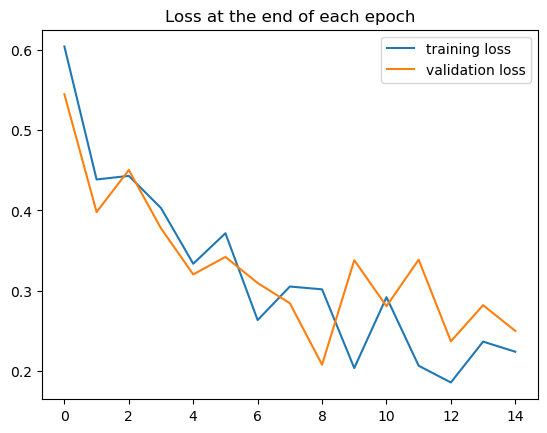

In [8]:
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()


[750, 815, 826, 862, 851, 862, 845, 879, 882, 876, 868, 876, 879, 874, 885]
Test accuracy: 88.500%


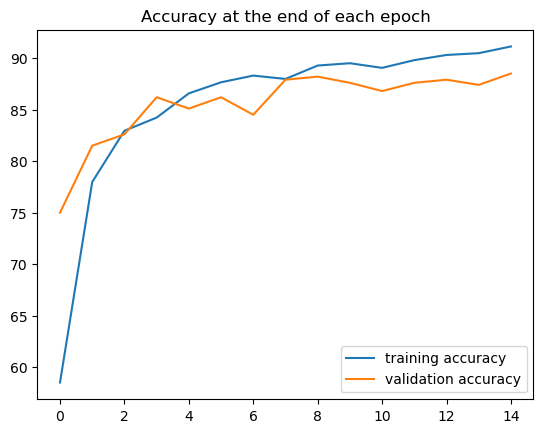

In [9]:
print(val_correct)
print(f'Test accuracy: {val_correct[-1]*100/1000:.3f}%')
plt.plot([t/40 for t in train_correct], label='training accuracy')
plt.plot([t/10 for t in val_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();